In [1]:
import numpy as np
import data

import sys
sys.path.append('../..')

import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

In [3]:
class GFGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, K, bias=True):
        super().__init__()
        self.K = K
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.W = nn.Parameter(torch.empty((self.K, self.in_dim, self.out_dim)))
        torch.nn.init.kaiming_uniform_(self.W.data)

        if bias:
            self.b = nn.Parameter(torch.empty(self.out_dim))
            torch.nn.init.constant_(self.b.data, 0.)
        else:
            self.b = None
        
    def forward(self, X, S):

        M, Nin, Fin = X.shape
        Ns = S.shape[0]
        assert Nin == Ns
        assert Fin == self.in_dim

        X_out = X @ self.W[0,:,:]
        Sx = X
        for k in range(1, self.K):
            Sx = S @ Sx
            X_out += Sx @ self.W[k,:,:]

        if self.b is not None:
            return X_out + self.b[None,None,:]
        else:
            return X_out
        

class GFGCN(nn.Module):
    def __init__(self, S, in_dim, hid_dim, out_dim, n_layers, K, bias=True,
                 act=nn.ReLU, last_act=nn.Identity, dropout=0,
                 diff_layer=GFGCNLayer, norm_S=False, batch_norm=False):
        super().__init__()
        self.S = nn.Parameter(S)
        self.act = act()
        self.last_act = last_act()
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.bias = bias

        self.batch_norm = batch_norm
        if self.batch_norm:
            self.batch_norm_layers = nn.ModuleList()

        if norm_S:
            self.normalize_S()

        self.convs = nn.ModuleList()
        if n_layers > 1:
            self.convs.append(diff_layer(in_dim, hid_dim, K, bias))
            if self.batch_norm:
                self.batch_norm_layers.append(nn.BatchNorm1d(hid_dim))
            for _ in range(n_layers - 2):
                self.convs.append(diff_layer(hid_dim, hid_dim, K, bias))
                if self.batch_norm:
                    self.batch_norm_layers.append(nn.BatchNorm1d(hid_dim))
            self.convs.append(diff_layer(hid_dim, out_dim, K, bias))
        else:
            self.convs.append(diff_layer(in_dim, out_dim, K, bias))

    def forward(self, X):
        for i in range(self.n_layers - 1):
            X = self.convs[i](X, self.S)
            X = self.act(X)
            if self.batch_norm:
                X = self.batch_norm_layers[i](X)
            X = self.dropout(X)
        X = self.convs[-1](X, self.S)
        return self.last_act(X)
    
    def normalize_S(self):
        unnorm_S = self.S.data.clone()
        d = unnorm_S.sum(1)
        D_inv = torch.diag(torch.sqrt(1/d))
        D_inv[torch.isinf(D_inv)] = 0.

        S_norm = D_inv @ unnorm_S @ D_inv

        self.S.data = S_norm

    def update_S(self, newS, normalize=True):
        self.S.data = newS
        if normalize:
            self.normalize_S()

In [4]:
def test(model, x, y, train_idx, val_idx, test_idx, lr, wd, n_epochs, es_patience=-1, eval_freq=4, verbose=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = nn.MSELoss()

    loss_train, loss_val, loss_test = [np.zeros(n_epochs) for _ in range(3)]

    best_val_loss = np.inf
    best_test_loss = 0
    es_count = 0

    for i in range(n_epochs):
        yhat = model(x)
        loss = loss_fn(yhat[train_idx,:,:], y[train_idx,:,:])

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_train[i] = loss.item()
        loss_val[i] = ((yhat[val_idx,:,:] - y[val_idx,:,:])**2).mean().item()
        loss_test[i] = ((yhat[test_idx,:,:] - y[test_idx,:,:])**2).mean().item()

        if loss_val[i] < best_val_loss:
            es_count = 0
            best_val_loss = loss_val[i]
            best_test_loss = loss_test[i]
        else:
            es_count += 1

        if es_patience > 0 and es_count > es_patience:
            break

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Train Loss: {loss_train[i]} - Val Loss: {loss_val[i]} - Test Loss: {loss_test[i]}", flush=True)

    return loss_train, loss_val, loss_test, best_val_loss, best_test_loss

# Data Generation

In [5]:
N = 20
p_er = 0.2
g_params = {'type': data.ER, 'p': p_er}
norm_S = False
norm_H = False
sort_h = False
neg_coefs = False
exp_coefs = True
pert_type = "rewire"

M = 100
p_n = 0.05
eps = 0.15
K = 3

In [6]:
X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

In [7]:
X.shape

(20, 100)

In [90]:
X = torch.tensor(X).to(device).T[:,:,None].double()
Y = torch.tensor(Y).to(device).T[:,:,None].double()
S = torch.tensor(S).to(device).double()
Sn = torch.tensor(Sn).to(device).double()

In [91]:
X.shape, Y.shape, S.shape

(torch.Size([100, 20, 1]), torch.Size([100, 20, 1]), torch.Size([20, 20]))

# Model Training

In [92]:
in_dim = 1
out_dim = 1

hid_dim = 32
n_layers = 2
K = 3
bias = True
act = torch.nn.Tanh

lr = 1e-2
wd = 1e-4
n_epochs = 500

In [93]:
idxs_y_split = torch.randperm(M)
N_train = 0.7
N_val = 0.15
train_idx = idxs_y_split[:int(N_train*M)]
val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
test_idx = idxs_y_split[int((N_train+N_val)*M):]

In [94]:
# With real GSO S
model = GFGCN(S, in_dim, hid_dim, out_dim, n_layers, K, bias=bias, act=act).double().to(device)

loss_train, loss_val, loss_test, best_val_loss, best_test_loss = test(model, X, Y, train_idx, val_idx, test_idx, lr, wd, n_epochs, eval_freq=50, verbose=True)

Epoch 1/500 - Train Loss: 14.716885419510078 - Val Loss: 12.172661821195234 - Test Loss: 13.693088228611755
Epoch 50/500 - Train Loss: 0.04845674391158521 - Val Loss: 0.05301850527453475 - Test Loss: 0.053644490122731155
Epoch 100/500 - Train Loss: 0.013789679218649457 - Val Loss: 0.012234853194323868 - Test Loss: 0.01431288094242515
Epoch 150/500 - Train Loss: 0.010965155282549505 - Val Loss: 0.009714982362643463 - Test Loss: 0.011245131417042049
Epoch 200/500 - Train Loss: 0.009552327640429703 - Val Loss: 0.00861213496706978 - Test Loss: 0.009770074794312779
Epoch 250/500 - Train Loss: 0.008678425185825641 - Val Loss: 0.007886297216585418 - Test Loss: 0.008917052065138733
Epoch 300/500 - Train Loss: 0.00808688892751657 - Val Loss: 0.0073719484707560675 - Test Loss: 0.008381188339429144
Epoch 350/500 - Train Loss: 0.007647799430133933 - Val Loss: 0.006988183914329772 - Test Loss: 0.008009234523994813
Epoch 400/500 - Train Loss: 0.007287727521786562 - Val Loss: 0.006686127128927363 - T

In [95]:
# With perturbed GSO Sn
model = GFGCN(Sn, in_dim, hid_dim, out_dim, n_layers, K, bias=bias, act=act).double().to(device)

loss_train, loss_val, loss_test, best_val_loss, best_test_loss = test(model, X, Y, train_idx, val_idx, test_idx, lr, wd, n_epochs, eval_freq=50, verbose=True)

Epoch 1/500 - Train Loss: 12.8922449088904 - Val Loss: 9.138939127694407 - Test Loss: 11.6262453259054
Epoch 50/500 - Train Loss: 0.03356696901248965 - Val Loss: 0.037114170538351095 - Test Loss: 0.036218435914282324
Epoch 100/500 - Train Loss: 0.019009697347684224 - Val Loss: 0.017774511704326503 - Test Loss: 0.02154127826278645
Epoch 150/500 - Train Loss: 0.01398738899702521 - Val Loss: 0.013793964944039831 - Test Loss: 0.01650746544723771
Epoch 200/500 - Train Loss: 0.011289457358817843 - Val Loss: 0.011408520096213388 - Test Loss: 0.013713567660810132
Epoch 250/500 - Train Loss: 0.0097884022055602 - Val Loss: 0.009958786926620267 - Test Loss: 0.012091854980349846
Epoch 300/500 - Train Loss: 0.008923553652442443 - Val Loss: 0.009066971133605781 - Test Loss: 0.011121278313889095
Epoch 350/500 - Train Loss: 0.008373740098260581 - Val Loss: 0.008488341469980142 - Test Loss: 0.010493514566580124
Epoch 400/500 - Train Loss: 0.007964413176521494 - Val Loss: 0.008071658004682528 - Test Los

# Exhaustive

In [96]:
n_graphs = 25

loss_test_pertless = np.zeros(n_graphs)
loss_test_pert = np.zeros(n_graphs)

for g in range(n_graphs):
    print(f"{g+1} ", end="")
    X, Y, Cy, Cy_samp, H, S, Sn, h = data.gen_data(N, M, g_params, p_n, eps, K, neg_coefs=neg_coefs, exp_coefs=exp_coefs, sort_h=sort_h, norm_S=norm_S, norm_H=norm_H, pert_type=pert_type)

    X = torch.tensor(X).to(device).T[:,:,None].double()
    Y = torch.tensor(Y).to(device).T[:,:,None].double()
    S = torch.tensor(S).to(device).double()
    Sn = torch.tensor(Sn).to(device).double()

    idxs_y_split = torch.randperm(M)
    N_train = 0.7
    N_val = 0.15
    train_idx = idxs_y_split[:int(N_train*M)]
    val_idx = idxs_y_split[int(N_train*M):int((N_train+N_val)*M)]
    test_idx = idxs_y_split[int((N_train+N_val)*M):]

    # With real GSO S
    model = GFGCN(S, in_dim, hid_dim, out_dim, n_layers, K, bias=bias, act=act).double().to(device)

    loss_train, loss_val, loss_test, best_val_loss, loss_test_pertless[g] = test(model, X, Y, train_idx, val_idx, test_idx, lr, wd, n_epochs, eval_freq=50, verbose=False)

    model = GFGCN(Sn, in_dim, hid_dim, out_dim, n_layers, K, bias=bias, act=act).double().to(device)

    loss_train, loss_val, loss_test, best_val_loss, loss_test_pert[g] = test(model, X, Y, train_idx, val_idx, test_idx, lr, wd, n_epochs, eval_freq=50, verbose=False)

1 

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [97]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7f0f0c2e0d00>,
 [Text(1, 0, 'With Perturbations'), Text(2, 0, 'Without Perturbations')])

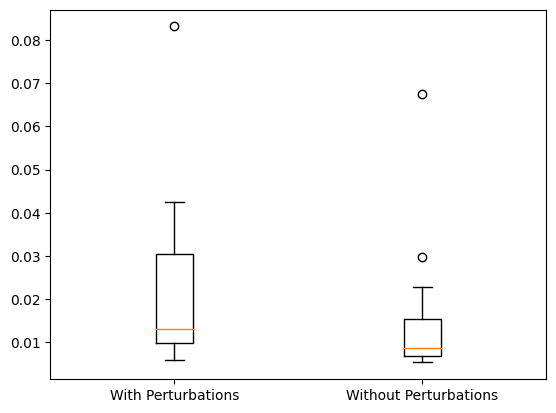

In [98]:
plt.boxplot([loss_test_pert, loss_test_pertless])
plt.xticks(np.arange(1,3), ["With Perturbations", "Without Perturbations"])